In [1]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.colors as colors
import pandas as pd
from fix_grid import fix_grid 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data

In [2]:
pathp='/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/'
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'
dsa=xr.open_dataset(pathf+'3x3box_mean_anomaly_monthly_0181-0190_all.nc', chunks='auto')
ds=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/mean_std_control_noice.nc', chunks='auto')
ds_cc=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/mean_std_1PctTo2X_noice.nc', chunks='auto')
ds_smoothed=xr.open_dataset(pathf+'3x3box_mean_monthly_0181-0190_noice_all.nc')
ds_smoothed=fix_grid(ds_smoothed)
dsa=fix_grid(dsa)
ds=fix_grid(ds)
ds_cc=fix_grid(ds_cc)
co2=abs(dsa.dic_stf)
o2=abs(dsa.o2_stf)

co2_cc=abs(dsa.dic_stf_1PctTo2X)
o2_cc=abs(dsa.o2_stf_1PctTo2X)

co2=co2.mean(dim='time')
o2=o2.mean(dim='time')

co2_cc=co2_cc.mean(dim='time')
o2_cc=o2_cc.mean(dim='time')

dif=co2/o2

dic_xmean=ds.dic_stf_mean.mean(dim='xt_ocean')
o2_xmean=ds.o2_stf_mean.mean(dim='xt_ocean')

ratio_co2=co2.mean(dim='xt_ocean')/abs(dic_xmean)
ratio_o2=o2.mean(dim='xt_ocean')/abs(o2_xmean)

# Plotting global maps

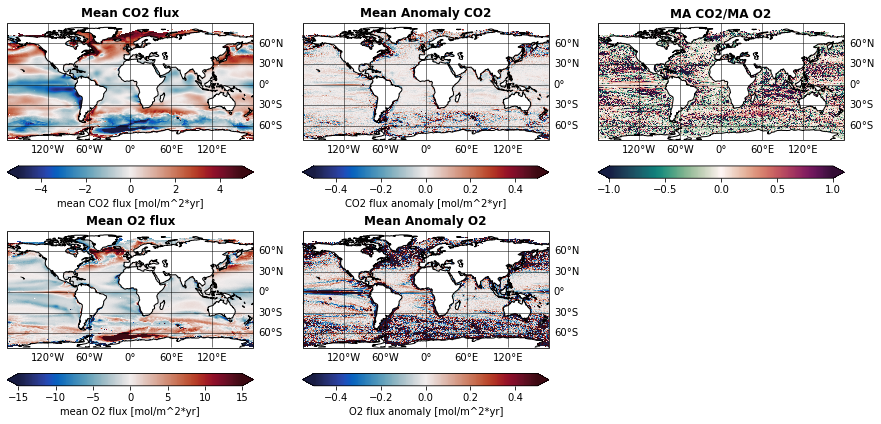

In [3]:
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(15,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
ds.dic_stf_mean.plot(ax=axs[0],vmin=-5, vmax=5, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mol/m^2*yr]"})
ds.o2_stf_mean.plot(ax=axs[3], vmin=-15, vmax=15, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal','label': "mean O2 flux [mol/m^2*yr]"})

dsa.dic_stf.mean(dim='time').plot(ax=axs[1],vmin=-.5, vmax=.5, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal','label': "CO2 flux anomaly [mol/m^2*yr]"})
dsa.o2_stf.mean(dim='time').plot(ax=axs[4], vmin=-.5, vmax=.5, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal','label': "O2 flux anomaly [mol/m^2*yr]"})

(dsa.dic_stf.mean(dim='time')/dsa.o2_stf.mean(dim='time')).plot(ax=axs[2],vmin=-1, vmax=1, x='geolon_t', y='geolat_t', cmap=cmo.curl, transform = ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})



for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

axs[0].set_title('Mean CO2 flux', fontweight='bold');
axs[3].set_title('Mean O2 flux', fontweight='bold');
axs[4].set_title('Mean Anomaly O2', fontweight='bold');
axs[1].set_title('Mean Anomaly CO2', fontweight='bold');
axs[2].set_title('MA CO2/MA O2', fontweight='bold');

axs[5].set_axis_off()

plt.savefig(pathp+'co2_o2_MA.png', dpi=300, bbox_inches='tight');

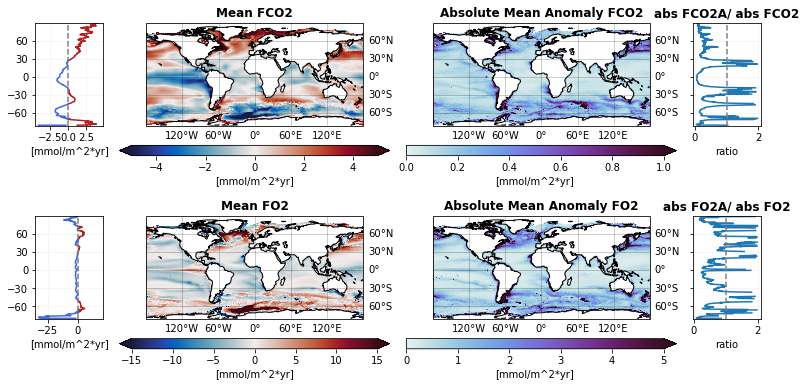

In [18]:
fig = plt.figure(figsize=(13,6),layout='compressed')
gs = gridspec.GridSpec(5, 4, width_ratios=[1,4,4,1],height_ratios=[1,.1,.2,1,.1], wspace=.1, hspace=.4)
ax1 = fig.add_subplot(gs[1],projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[2],projection=ccrs.PlateCarree(central_longitude=0))
#ax3 = fig.add_subplot(gs[3],projection=ccrs.PlateCarree(central_longitude=0))
ax13 = fig.add_subplot(gs[13],projection=ccrs.PlateCarree(central_longitude=0))
ax14 = fig.add_subplot(gs[14],projection=ccrs.PlateCarree(central_longitude=0))
#ax15 = fig.add_subplot(gs[15],projection=ccrs.PlateCarree(central_longitude=0))


#
#
im1=ds.dic_stf_mean.plot(ax=ax1, x='geolon_t', y='geolat_t',vmin=-5, vmax=5, cmap=cmo.balance, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})
ax5=fig.add_subplot(gs[5])
cbar1=plt.colorbar(im1, cax=ax5, orientation='horizontal',label= "[mmol/m^2*yr]",extend='both')

im2=co2.plot(ax=ax2, x='geolon_t', y='geolat_t',vmin=0, vmax=1, cmap=cmo.dense, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})
ax6=fig.add_subplot(gs[6])
cbar2=plt.colorbar(im2, cax=ax6, orientation='horizontal',label= "[mmol/m^2*yr]",extend='max')

#im3=ratio_co2.plot(ax=ax3, x='geolon_t', y='geolat_t',vmin=0, vmax=2, cmap=cmo.curl, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})
#ax7=fig.add_subplot(gs[7])
#cbar3=plt.colorbar(im3, cax=ax7, orientation='horizontal',extend='max')

im4=ds.o2_stf_mean.plot(ax=ax13, x='geolon_t', y='geolat_t',vmin=-15, vmax=15, cmap=cmo.balance, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})
ax17=fig.add_subplot(gs[17])
cbar4=plt.colorbar(im4, cax=ax17, orientation='horizontal',label= "[mmol/m^2*yr]",extend='both')

im5=o2.plot(ax=ax14, x='geolon_t', y='geolat_t',vmin=0, vmax=5, cmap=cmo.dense, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})
ax18=fig.add_subplot(gs[18])
cbar5=plt.colorbar(im5, cax=ax18, orientation='horizontal',label= "[mmol/m^2*yr]",extend='max')

#im6=ratio_co2.plot(ax=ax15, x='geolon_t', y='geolat_t',vmin=0, vmax=2, cmap=cmo.curl, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})
#ax19=fig.add_subplot(gs[19])
#cbar6=plt.colorbar(im6, cax=ax19, orientation='horizontal',extend='max')



axs=[ax1, ax2, ax13, ax14]
for i in axs:
        gl = i.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0.2)
        gl.xlabels_top = False
        gl.ylabels_left = False
        i.coastlines()
#

####LINEPLOTS
ax0 = fig.add_subplot(gs[0])
dic_xmean.where(dic_xmean>=0).plot(ax=ax0, y='yt_ocean', c='firebrick')
dic_xmean.where(dic_xmean<0).plot(ax=ax0, y='yt_ocean', c='royalblue')
ax0.axvline(0, c='gray', linestyle='--')
ax0.set_yticks([-60,-30,0,30,60])

ax12 = fig.add_subplot(gs[12])
o2_xmean.where(o2_xmean>=0).plot(ax=ax12, y='yt_ocean', c='firebrick')
o2_xmean.where(o2_xmean<0).plot(ax=ax12, y='yt_ocean', c='royalblue')
ax12.axvline(0, c='gray', linestyle='--')
ax12.set_yticks([-60,-30,0,30,60])

ax3 = fig.add_subplot(gs[3])
ratio_co2.where(ratio_co2<=2).plot(ax=ax3, y='yt_ocean')
ax3.set_yticks([-60,-30,0,30,60])


ax15 = fig.add_subplot(gs[15])
ratio_o2.where(ratio_o2<=2).plot(ax=ax15, y='yt_ocean')
ax15.set_yticks([-60,-30,0,30,60])


###TITLES AND LABELS
ax0.set_title('')
ax1.set_title('Mean FCO2', fontweight='bold');
ax2.set_title('Absolute Mean Anomaly FCO2', fontweight='bold');
ax3.set_title('abs FCO2A/ abs FCO2', fontweight='bold')

ax12.set_title('');
ax13.set_title('Mean FO2', fontweight='bold');
ax14.set_title('Absolute Mean Anomaly FO2', fontweight='bold');
ax15.set_title('abs FO2A/ abs FO2', fontweight='bold');

ax0.set_xlabel('[mmol/m^2*yr]');
ax0.set_ylabel('');

ax3.set_ylabel('');
ax3.set_xlabel('ratio');

ax12.set_xlabel('[mmol/m^2*yr]');
ax12.set_ylabel('')

ax15.set_ylabel('');
ax15.set_xlabel('ratio');

ax3.yaxis.set_ticklabels([])
ax3.grid(c='lightgray', linewidth=.5, linestyle='dotted')

ax15.yaxis.set_ticklabels([])
ax15.grid(c='lightgray', linewidth=.5, linestyle='dotted')

ax3.set_ylim([-81.108632,89.978896])
ax15.set_ylim([-81.108632,89.978896])
ax0.set_ylim([-81.108632,89.978896])
ax12.set_ylim([-81.108632,89.978896])
ax12.grid(c='lightgray', linewidth=.5, linestyle='dotted')
ax0.grid(c='lightgray', linewidth=.5, linestyle='dotted')
ax3.axvline(1, c='gray', linestyle='--')
ax15.axvline(1, c='gray', linestyle='--')


plt.savefig(pathp+'co2_o2_AMA_absratio_lines_new.png', dpi=300, bbox_inches='tight');

# pdf of global gas anomalies

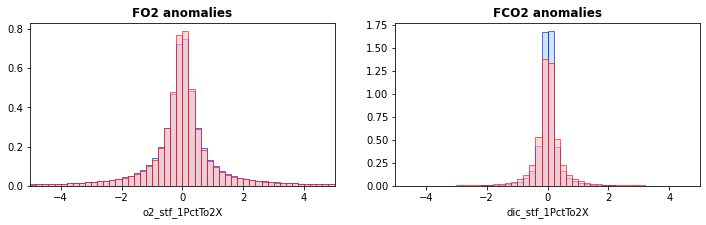

In [5]:
####Climate Change vs Ctrl
fig, axs= plt.subplots(nrows=1, ncols=2, figsize=(12,3))
### median und mean
dsa.o2_stf.where(dsa.o2_stf<=8).where(dsa.o2_stf>=-8).plot.hist(ax=axs[0],xlim=[-5,5], bins=80, color='lightblue',alpha=.6, edgecolor='blue', density=True);
dsa.o2_stf_1PctTo2X.where(dsa.o2_stf_1PctTo2X<=8).where(dsa.o2_stf_1PctTo2X>=-8).plot.hist(ax=axs[0], xlim=[-5,5], bins=80, color='pink',alpha=.6, edgecolor='red', density=True);
axs[0].set_title('FO2 anomalies', fontweight='bold')

dsa.dic_stf.where(dsa.dic_stf<=8).where(dsa.dic_stf>=-8).plot.hist(ax=axs[1], xlim=[-5,5], bins=80, color='lightblue',alpha=.6, edgecolor='blue', density=True);
dsa.dic_stf_1PctTo2X.where(dsa.dic_stf_1PctTo2X<=8).where(dsa.dic_stf_1PctTo2X>=-8).plot.hist(ax=axs[1],xlim=[-5,5], bins=80, color='pink',alpha=.6, edgecolor='red', density=True);
axs[1].set_title('FCO2 anomalies', fontweight='bold')

plt.savefig(pathp+'flux_pdf.png', dpi=300, bbox_inches='tight');

# bar plot with global effects

In [6]:
def weighted_means(data, names):
    weights = np.cos(np.deg2rad(dsa.dic_stf.yt_ocean))
    weights.name = "weights"
    res=[]
    for i,item in enumerate(data):
        item_w=item.weighted(weights).mean(("xt_ocean", "yt_ocean"))
        item_w.name=names[i]
        res.append(item_w)
    res=xr.merge(res)
    return res

In [7]:
#MA
res_AMA=weighted_means([co2, co2_cc, o2, o2_cc], ['FCO2 anomalies ctrl', 'FCO2 anomalies 1PctTo2X', 'FO2 anomalies ctrl', 'FO2 anomalies 1PctTo2X'])
#AMA
res_MA=weighted_means([dsa.dic_stf.mean(dim='time'), dsa.dic_stf_1PctTo2X.mean(dim='time'), dsa.o2_stf.mean(dim='time'), dsa.o2_stf_1PctTo2X.mean(dim='time')], ['FCO2 anomalies ctrl', 'FCO2 anomalies 1PctTo2X', 'FO2 anomalies ctrl', 'FO2 anomalies 1PctTo2X'])
#abs
res_abs=weighted_means([ds.dic_stf_mean, ds_cc.dic_stf_mean, ds.o2_stf_mean, ds_cc.o2_stf_mean], ['FCO2 ctrl', 'FCO2 1PctTo2X', 'FO2 ctrl', 'FO2 1PctTo2X'])

In [8]:
ctrlma=[res_MA['FCO2 anomalies ctrl'].values, res_MA['FO2 anomalies ctrl'].values]
climma=[res_MA['FCO2 anomalies 1PctTo2X'].values, res_MA['FO2 anomalies 1PctTo2X'].values]

ctrlama=[res_AMA['FCO2 anomalies ctrl'].values, res_AMA['FO2 anomalies ctrl'].values]
climama=[res_AMA['FCO2 anomalies 1PctTo2X'].values, res_AMA['FO2 anomalies 1PctTo2X'].values]

ctrlm=[res_abs['FCO2 ctrl'].values, res_abs['FO2 ctrl'].values]
climm=[res_abs['FCO2 1PctTo2X'].values, res_abs['FO2 1PctTo2X'].values]

In [9]:
index = ['FCO2', 'FO2']

dfma = pd.DataFrame({'ctrl': ctrlma,
                   '1PctTo2X': climma}, index=index).astype(float)

dfama = pd.DataFrame({'ctrl': ctrlama,
                   '1PctTo2X': climama}, index=index).astype(float)


df = pd.DataFrame({'ctrl': ctrlm,
                   '1PctTo2X': climm}, index=index).astype(float)

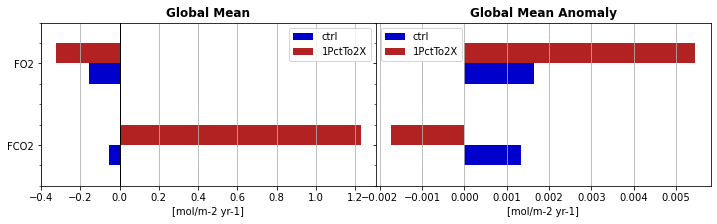

In [10]:
fig,axs=plt.subplots(1,2, figsize=(12,3), sharey=True)


axs[0].set_title('Global Mean', fontweight='bold')
df.plot.barh(ax=axs[0], color=['mediumblue', 'firebrick'])
axs[0].set_xlabel('[mol/m-2 yr-1]')
axs[0].axvline(0, c='black', linewidth=1)

axs[1].set_title('Global Mean Anomaly', fontweight='bold')
dfma.plot.barh(ax=axs[1], color=['mediumblue', 'firebrick'])
axs[1].set_xlabel('[mol/m-2 yr-1]');
axs[0].xaxis.grid()
axs[1].xaxis.grid()
plt.subplots_adjust(wspace=0)
plt.savefig(pathp+'barplot_MA.png', dpi=300, bbox_inches='tight');

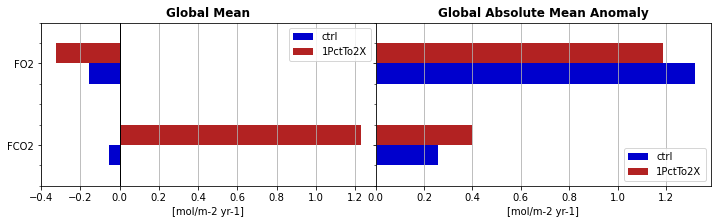

In [11]:
fig,axs=plt.subplots(1,2, figsize=(12,3), sharey=True)


axs[0].set_title('Global Mean', fontweight='bold')
df.plot.barh(ax=axs[0], color=['mediumblue', 'firebrick'])
axs[0].set_xlabel('[mol/m-2 yr-1]')
axs[0].axvline(0, c='black', linewidth=1)

axs[1].set_title('Global Absolute Mean Anomaly', fontweight='bold')
dfama.plot.barh(ax=axs[1], color=['mediumblue', 'firebrick'])
axs[1].set_xlabel('[mol/m-2 yr-1]');
axs[0].xaxis.grid()
axs[1].xaxis.grid()
plt.subplots_adjust(wspace=0)
plt.savefig(pathp+'barplot_AMA.png', dpi=300, bbox_inches='tight');

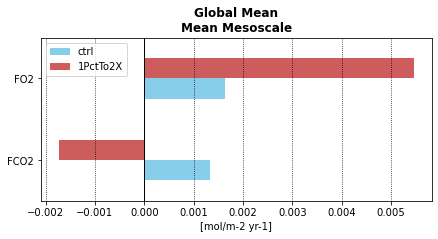

In [12]:
fig,axs=plt.subplots(1,1, figsize=(7,3))

axs.set_title('Global Mean\nMean Mesoscale', fontweight='bold')
dfma.plot.barh(ax=axs, color=['skyblue', 'indianred'])
axs.set_xlabel('[mol/m-2 yr-1]')
axs.axvline(0, c='black', linewidth=1)
axs.xaxis.grid(c='black', linestyle='dotted')
plt.savefig(pathp+'barplot_MA_alone.png', dpi=300, bbox_inches='tight');

In [43]:
### clim Differences to ctrl

In [13]:
def climateffect(clim, ctrl):
    dif=[]
    for iclim, ictrl in zip(clim,ctrl):
        bias=iclim-ictrl
        dif.append(bias)
    return dif

In [14]:
#first number is CO2, second O2
difma=climateffect(climma, ctrlma)
difama=climateffect(climama, ctrlama)
difabs=climateffect(climm, ctrlm)

In [15]:
#plotting
index = ['FCO2', 'FO2']

df_all = pd.DataFrame({'mean total': difabs,
                   'mean abs. mesoscale': difama,
                    'mean mesoscale x 100': [i*100 for i in difma]}, index=index).astype(float)

In [16]:
df_all

,mean total,mean abs. mesoscale,mean mesoscale x 100
FCO2,1.283523,0.142860,-0.306407
FO2,-0.168795,-0.131902,0.381648


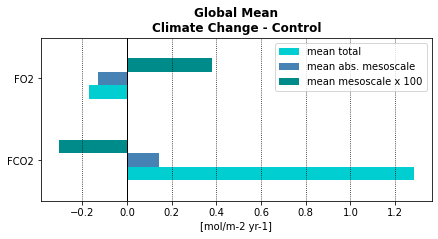

In [17]:
fig,axs=plt.subplots(1,1, figsize=(7,3))

axs.set_title('Global Mean\nClimate Change - Control', fontweight='bold')
df_all.plot.barh(ax=axs, color=['darkturquoise', 'steelblue', 'darkcyan'])
axs.set_xlabel('[mol/m-2 yr-1]')
axs.axvline(0, c='black', linewidth=1)
axs.xaxis.grid(c='black', linestyle='dotted')
plt.savefig(pathp+'barplot_diff_climate.png', dpi=300, bbox_inches='tight');

# binned correlation (not updated)

In [10]:
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'
dsa=xr.open_dataset(pathf+'3x3box_anomaly_monthly_0181-0190.nc')


In [26]:
test=xr.merge([dsa.SST[::, ::10,::10], dsa['sens_heat'][::, ::10,::10], dsa['evap_heat'][::, ::10,::10], dsa['o2_stf'][::, ::10,::10], dsa['dic_stf'][::, ::10,::10]])
#step1=np.arange(-3,-2, .5)
step2=np.arange(-3,3, .25)
#step3=np.arange(2,4.5,.5)
step=np.concatenate((step1,step2,step3))

In [29]:
test=test.to_dataframe()

In [30]:
bins = pd.cut(test['SST'], step2)
test['bins'] = bins

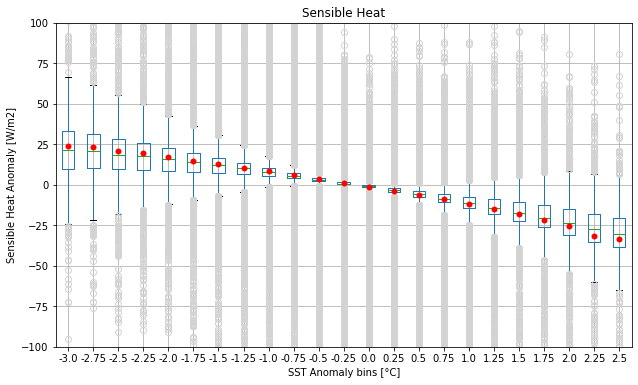

In [32]:
flierprops = dict(marker='o', markerfacecolor='none', markersize=6,markeredgecolor='lightgray')
meanpointprops = dict(marker='o', markeredgecolor='none',
                      markerfacecolor='red')

fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(10,6))
test.boxplot(ax=ax, column="sens_heat", by='bins', showmeans=True, flierprops=flierprops,meanprops=meanpointprops)
ax.set_xticklabels(list(step2[:-1]));
ax.set_title('Sensible Heat')
ax.set_xlabel('SST Anomaly bins [°C]')
ax.set_ylabel('Sensible Heat Anomaly [W/m2]')
fig.suptitle('')

ax.set_ylim([-100,100])
plt.savefig(pathp+'sens_heat_boxplot_crop.png', dpi=300, bbox_inches='tight');

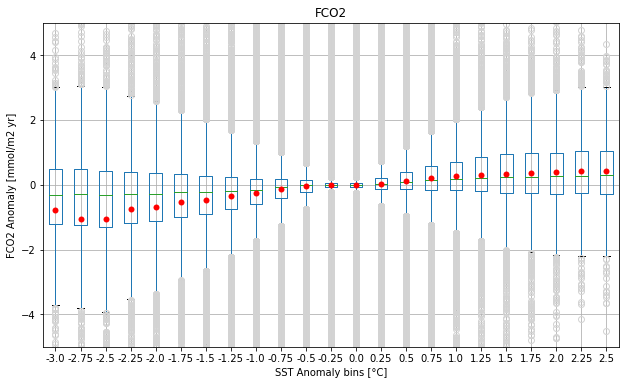

In [44]:
flierprops = dict(marker='o', markerfacecolor='none', markersize=6,markeredgecolor='lightgray')
meanpointprops = dict(marker='o', markeredgecolor='none',
                      markerfacecolor='red')

fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(10,6))
test.boxplot(ax=ax, column="dic_stf", by='bins', showmeans=True, flierprops=flierprops,meanprops=meanpointprops)
ax.set_xticklabels(list(step2[:-1]));
ax.set_title('FCO2')
ax.set_xlabel('SST Anomaly bins [°C]')
ax.set_ylabel('FCO2 Anomaly [mmol/m2 yr]')
fig.suptitle('')

ax.set_ylim([-5,5])
plt.savefig(pathp+'dic_stf_boxplot_crop.png', dpi=300, bbox_inches='tight');

# monthly 0181-0190 control (not updated)

## correlations

### SSH corr

In [ ]:
sh=dsa.sens_heat
lh=dsa.evap_heat
o2=dsa.o2_stf
dic=dsa.dic_stf
ssh=dsa.SSH
sst=dsa.SST

In [5]:
ds_corr=fix_grid(ds_corr)

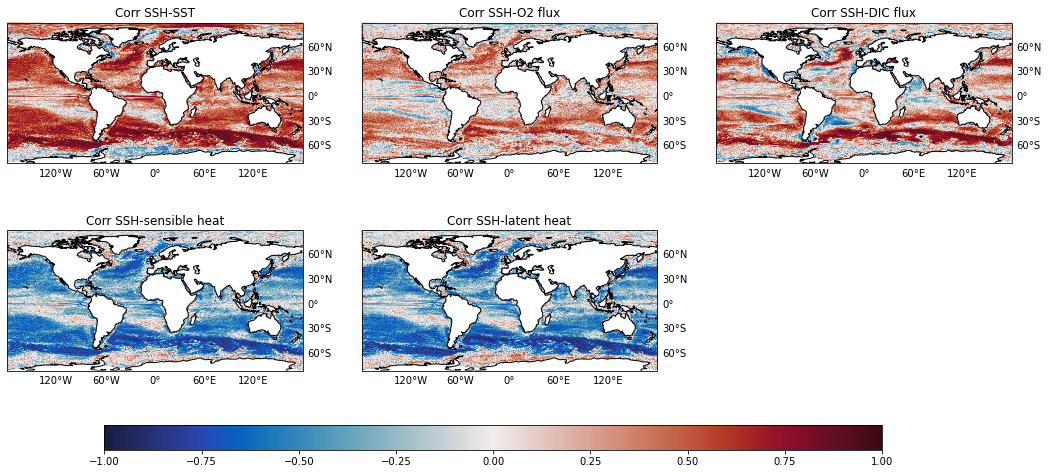

In [6]:
###SSH corrs
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(18,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im =ds_corr.corr_ssh_SST.plot(ax=axs[0], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_ssh_sens_heat.plot(ax=axs[3], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_ssh_evap_heat.plot(ax=axs[4], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_ssh_o2_stf.plot(ax=axs[1], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_ssh_dic_stf.plot(ax=axs[2], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
axs[5].set_axis_off()

for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

axs[0].set_title('Corr SSH-SST');
axs[3].set_title('Corr SSH-sensible heat');
axs[4].set_title('Corr SSH-latent heat');
axs[1].set_title('Corr SSH-O2 flux');
axs[2].set_title('Corr SSH-DIC flux');
#plt.savefig(pathp+'3x3box_corr_monthly_0181-0190.png', bbox_inches="tight", dpi=300)
plt.savefig(pathp+'3x3box_corr_monthly_1PctTo2X_0181-0190.png', bbox_inches="tight", dpi=300)

In [ ]:
###SSH corrs
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(18,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im =ds_corr.corr_ssh_SST.plot.contourf(ax=axs[0], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False, levels=np.linspace(-1,1,5))
ds_corr.corr_ssh_sens_heat.plot.contourf(ax=axs[3], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False, levels=np.linspace(-1,1,5))
ds_corr.corr_ssh_evap_heat.plot.contourf(ax=axs[4], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False, levels=np.linspace(-1,1,5))
ds_corr.corr_ssh_o2_stf.plot.contourf(ax=axs[1], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False, levels=np.linspace(-1,1,5))
ds_corr.corr_ssh_dic_stf.plot.contourf(ax=axs[2], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False, levels=np.linspace(-1,1,5))
axs[5].set_axis_off()

for i in range(5):
    #axs[i].yaxis.tick_right()
    #axs[i].set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    #axs[i].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    #lon_formatter = LongitudeFormatter(zero_direction_label=True)
    #lat_formatter = LatitudeFormatter()
    #axs[i].xaxis.set_major_formatter(lon_formatter)
    #axs[i].yaxis.set_major_formatter(lat_formatter)

    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

axs[0].set_title('Corr SSH-SST');
axs[3].set_title('Corr SSH-sensible heat');
axs[4].set_title('Corr SSH-latent heat');
axs[1].set_title('Corr SSH-O2 flux');
axs[2].set_title('Corr SSH-DIC flux');
plt.savefig(pathp+'3x3box_corr_contourf_monthly_1PctTo2X_0181-0190.png', bbox_inches="tight", dpi=300)
#plt.savefig(pathp+'3x3box_corr_contourf_monthly_0181-0190.png', bbox_inches="tight", dpi=300)

In [ ]:
###SST corrs
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(18,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im =ds_corr.corr_sst_SSH.plot(ax=axs[0], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_sens_heat.plot(ax=axs[3], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_evap_heat.plot(ax=axs[4], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_o2_stf.plot(ax=axs[1], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_dic_stf.plot(ax=axs[2], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
axs[5].set_axis_off()

for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

axs[0].set_title('Corr SST-SSH');
axs[3].set_title('Corr SST-sensible heat');
axs[4].set_title('Corr SST-latent heat');
axs[1].set_title('Corr SST-O2 flux');
axs[2].set_title('Corr SST-DIC flux');

plt.savefig(pathp+'3x3box_sstcorr_monthly_1PctTo2X_0181-0190.png', bbox_inches="tight", dpi=300)
#plt.savefig(pathp+'3x3box_sstcorr_monthly_0181-0190.png', bbox_inches="tight", dpi=300)

In [ ]:
###SST corrs
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(18,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im =ds_corr.corr_sst_SSH.plot.contourf(ax=axs[0], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_sens_heat.plot.contourf(ax=axs[3], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_evap_heat.plot.contourf(ax=axs[4], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_o2_stf.plot.contourf(ax=axs[1], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_corr.corr_sst_dic_stf.plot.contourf(ax=axs[2], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
axs[5].set_axis_off()

for i in range(5):
    #axs[i].yaxis.tick_right()
    #axs[i].set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    #axs[i].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    #lon_formatter = LongitudeFormatter(zero_direction_label=True)
    #lat_formatter = LatitudeFormatter()
    #axs[i].xaxis.set_major_formatter(lon_formatter)
    #axs[i].yaxis.set_major_formatter(lat_formatter)


    
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

axs[0].set_title('Corr SST-SSH');
axs[3].set_title('Corr SST-sensible heat');
axs[4].set_title('Corr SST-latent heat');
axs[1].set_title('Corr SST-O2 flux');
axs[2].set_title('Corr SST-DIC flux');

plt.savefig(pathp+'3x3box_sstcorr_contourf_monthly_1PctTo2X_0181-0190.png', bbox_inches="tight", dpi=300)
#plt.savefig(pathp+'3x3box_sstcorr_contourf_monthly_0181-0190.png', bbox_inches="tight", dpi=300)

### seasonal correlation

In [ ]:
###control
#seas=xr.open_dataset(pathf+'3x3box_corr_seasonally_0181-0190.nc')
### Climate Change
seas=xr.open_dataset(pathf+'3x3box_corr_seasonally_1PctTo2X_0181-0190.nc')
seas=fix_grid(seas)

In [ ]:
###SSH corrs
def seasonal_plotting(season):
    fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(18,7),subplot_kw={'projection': ccrs.PlateCarree()})
    axs=axs.flatten()
    im =seas.sel(season=season).corr_ssh_SST.plot.contourf(ax=axs[0], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    seas.sel(season=season).corr_ssh_sens_heat.plot.contourf(ax=axs[3], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    seas.sel(season=season).corr_ssh_evap_heat.plot.contourf(ax=axs[4], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    seas.sel(season=season).corr_ssh_o2_stf.plot.contourf(ax=axs[1], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    seas.sel(season=season).corr_ssh_dic_stf.plot.contourf(ax=axs[2], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    axs[5].set_axis_off()
    
    for i in range(5):
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0)
        gl.xlabels_top = False
        gl.ylabels_left = False
        axs[i].coastlines()
    
    cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    axs[0].set_title('Corr SSH-SST '+ season);
    axs[3].set_title('Corr SSH-sensible heat '+ season);
    axs[4].set_title('Corr SSH-latent heat '+ season);
    axs[1].set_title('Corr SSH-O2 flux '+ season);
    axs[2].set_title('Corr SSH-DIC flux '+ season);
    
    plt.savefig(pathp+'3x3box_corr_seasonally_'+season+'_1PctTo2X_0181-0190.png', bbox_inches="tight", dpi=300)
    #plt.savefig(pathp+'3x3box_corr_seasonally_'+season+'_0181-0190.png', bbox_inches="tight", dpi=300)

In [ ]:
seasonal_plotting('DJF')
seasonal_plotting('MAM')
seasonal_plotting('SON')
seasonal_plotting('JJA')

### for each variable independently

In [ ]:
for var in list(seas.keys()):
    fig, axs= plt.subplots(nrows=2, ncols=2 , figsize=(15,7),subplot_kw={'projection': ccrs.PlateCarree()})
    axs=axs.flatten()
    im=seas.sel(season='DJF')[var].plot.contourf(ax=axs[0], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    seas.sel(season='MAM')[var].plot.contourf(ax=axs[1], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    seas.sel(season='JJA')[var].plot.contourf(ax=axs[2], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    seas.sel(season='SON')[var].plot.contourf(ax=axs[3], x='geolon_t', y='geolat_t', vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
    
    for i in range(4):
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0)
        gl.xlabels_top = False
        gl.ylabels_right = False
        axs[i].coastlines()
    
    cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    axs[0].set_title('DJF '+var);
    axs[1].set_title('MAM '+var);
    axs[2].set_title('JJA '+var);
    axs[3].set_title('SON '+var);
    
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    #plt.savefig(pathp+'3x3box_'+var+'_seasonally_0181-0190.png', bbox_inches="tight", dpi=300)
    plt.savefig(pathp+'3x3box_'+var+'_seasonally_1PctTo2X_0181-0190.png', bbox_inches="tight", dpi=300)

## month 1


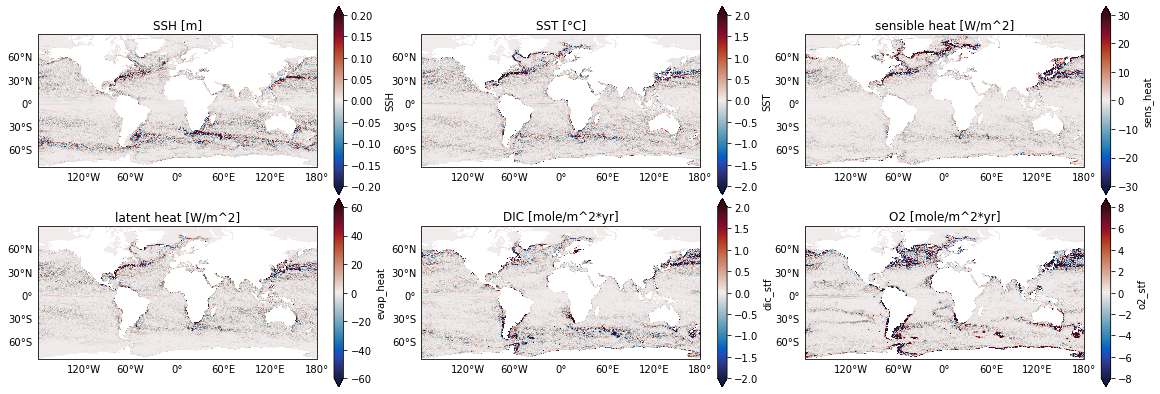

In [48]:
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(20,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
dsa.isel(month=0).SSH.plot(ax=axs[0], vmin=-.2, vmax=.2, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=True)
dsa.isel(month=0).SST.plot(ax=axs[1], vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=True)
dsa.isel(month=0).sens_heat.plot(ax=axs[2], vmin=-30, vmax=30, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=True)
dsa.isel(month=0).evap_heat.plot(ax=axs[3], vmin=-60, vmax=60, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=True)
dsa.isel(month=0).dic_stf.plot(ax=axs[4], vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=True)
dsa.isel(month=0).o2_stf.plot(ax=axs[5], vmin=-8, vmax=8, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=True)

for i in range(6):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_right = False


axs[0].set_title('SSH [m]');
axs[1].set_title('SST [°C]');
axs[2].set_title('sensible heat [W/m^2]');
axs[3].set_title('latent heat [W/m^2]');
axs[4].set_title('DIC [mole/m^2*yr]');
axs[5].set_title('O2 [mole/m^2*yr]');

plt.subplots_adjust(hspace=0.02, wspace=0.1)
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/3x3_boxcar_global_ano_month1.png', bbox_inches="tight", dpi=300)

## scatter

In [4]:
def scattering(var, spatial, label, filename): ##var =SST, sens_heat, evap_heat
    corr=np.round(xr.corr(sst[:, ::spatial, ::spatial], var[:, ::spatial, ::spatial]).values, 2)
    plt.figure(figsize=(12,8))
    plt.grid()
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    plt.scatter(sst[:, ::spatial, ::spatial].values.flatten(), 
                var[:, ::spatial, ::spatial].values.flatten(),
               color='gray', marker='x', label='correlation raw: '+str(corr))
    plt.xlabel('SST [°C]', fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.title('Anomalies', fontsize=23)
    plt.legend(loc=2, fontsize=20)
    #plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/scatters/3x3_boxcar_global_scatter_SST_'+filename+'_monthly.png', dpi=300)


### global

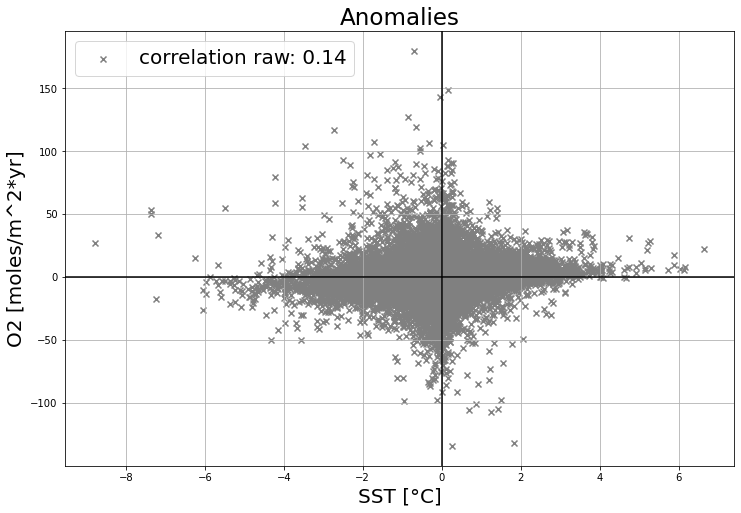

In [11]:
scattering(o2, 10, 'O2 [moles/m^2*yr]', 'o2')

### binned

In [8]:
def scattering(ds, var, spatial, label, filename): ##var =SST, sens_heat, evap_heat
    sst_var=xr.merge([ds.SSH, ds[var]])
    sst_var_b=sst_var.groupby_bins(sst_var.SSH, 10)
    bins=sst_var_b.mean('stacked_month_yt_ocean_xt_ocean')
    
    corr=np.round(xr.corr(ds.SSH[:, ::spatial, ::spatial], ds[var][:, ::spatial, ::spatial]).values, 2)
    corr_bins=np.round(xr.corr(bins.SSH, bins[var]).values, 2)

    
    plt.figure(figsize=(12,8))
    plt.grid()
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    plt.scatter(ds.SSH[:, ::spatial, ::spatial].values.flatten(), 
                ds[var][:, ::spatial, ::spatial].values.flatten(),
               color='gray', marker='x', label='correlation raw: '+str(corr))
    for i, item in enumerate(bins.SSH_bins.values):
        if i==1:
            plt.hlines(bins[var][i], xmin=item.left, xmax=item.right, color='red', label='correlation binned: '+str(corr_bins))
        else:
            plt.hlines(bins[var][i], xmin=item.left, xmax=item.right, color='red')


    
    plt.xlabel('SSH [m]', fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.title('Anomalies', fontsize=23)
    plt.legend(loc=2, fontsize=20)
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/scatters/3x3_boxcar_global_scatterbinned_SSH_'+filename+'_monthly.png', dpi=300)


In [ ]:
scattering(dsa, 'SST', 20, 'SST [°C]', 'sst')
scattering(dsa, 'sens_heat', 20, 'sensible heat [W/m^2]', 'sh')
scattering(dsa, 'evap_heat', 20, 'latent heat [W/m^2]', 'lh')
scattering(dsa, 'dic_stf', 20, 'CO2 [moles/(m^2*yr)]', 'dic')
scattering(dsa, 'o2_stf', 20, 'O2', 'o2')